In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import torch
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet
from monai.networks.utils import eval_mode
from monai.optimizers import LearningRateFinder
from monai.transforms import (
    Activations,
    AsDiscrete,
    EnsureChannelFirstd,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    ScaleIntensityd,
    EnsureTyped,
    EnsureType,
)
from monai.utils import set_determinism
from torch.utils.data import DataLoader
from tqdm import trange

#print_config()

In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmph8a6q38t


In [3]:
set_determinism(seed=0)

In [4]:
transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        ScaleIntensityd(keys="image"),
        CenterSpatialCropd(keys="image", roi_size=(20, 20)),
        EnsureTyped(keys="image"),
    ]
)

In [5]:
# Set fraction of images used for testing to be very high, then don't use it. In this way, we can reduce the number
# of images in both train and val. Makes it faster and makes the training a little harder.
def get_data(section):
    ds = MedNISTDataset(
        root_dir=root_dir,
        transform=transforms,
        section=section,
        download=True,
        num_workers=10,
        val_frac=0.0005,
        test_frac=0.995,
    )
    loader = DataLoader(ds, batch_size=30, shuffle=True, num_workers=10)
    return ds, loader


train_ds, train_loader = get_data("training")
val_ds, val_loader = get_data("validation")

print(len(train_ds))
print(len(val_ds))
print(train_ds[0]["image"].shape)
num_classes = train_ds.get_num_classes()

y_pred_trans = Compose([EnsureType(), Activations(softmax=True)])
y_trans = Compose([EnsureType(), AsDiscrete(to_onehot=num_classes)])

MedNIST.tar.gz: 59.0MB [00:03, 16.3MB/s]                                                                                     

2022-11-11 13:03:05,098 - INFO - Downloaded: /tmp/tmpgbk0b7kq/MedNIST.tar.gz


2022-11-11 13:03:05,192 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2022-11-11 13:03:05,193 - INFO - Writing into directory: /tmp/tmpgbk0b7kq.


Loading dataset: 100%|████████████████████████████████████████████████████████████████████| 266/266 [00:00<00:00, 564.68it/s]


2022-11-11 13:03:11,704 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2022-11-11 13:03:11,704 - INFO - File exists: /tmp/tmpgbk0b7kq/MedNIST.tar.gz, skipped downloading.
2022-11-11 13:03:11,704 - INFO - Non-empty folder exists in /tmp/tmpgbk0b7kq/MedNIST, skipped extracting.


Loading dataset: 100%|██████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 583.85it/s]

266
29
(1, 20, 20)


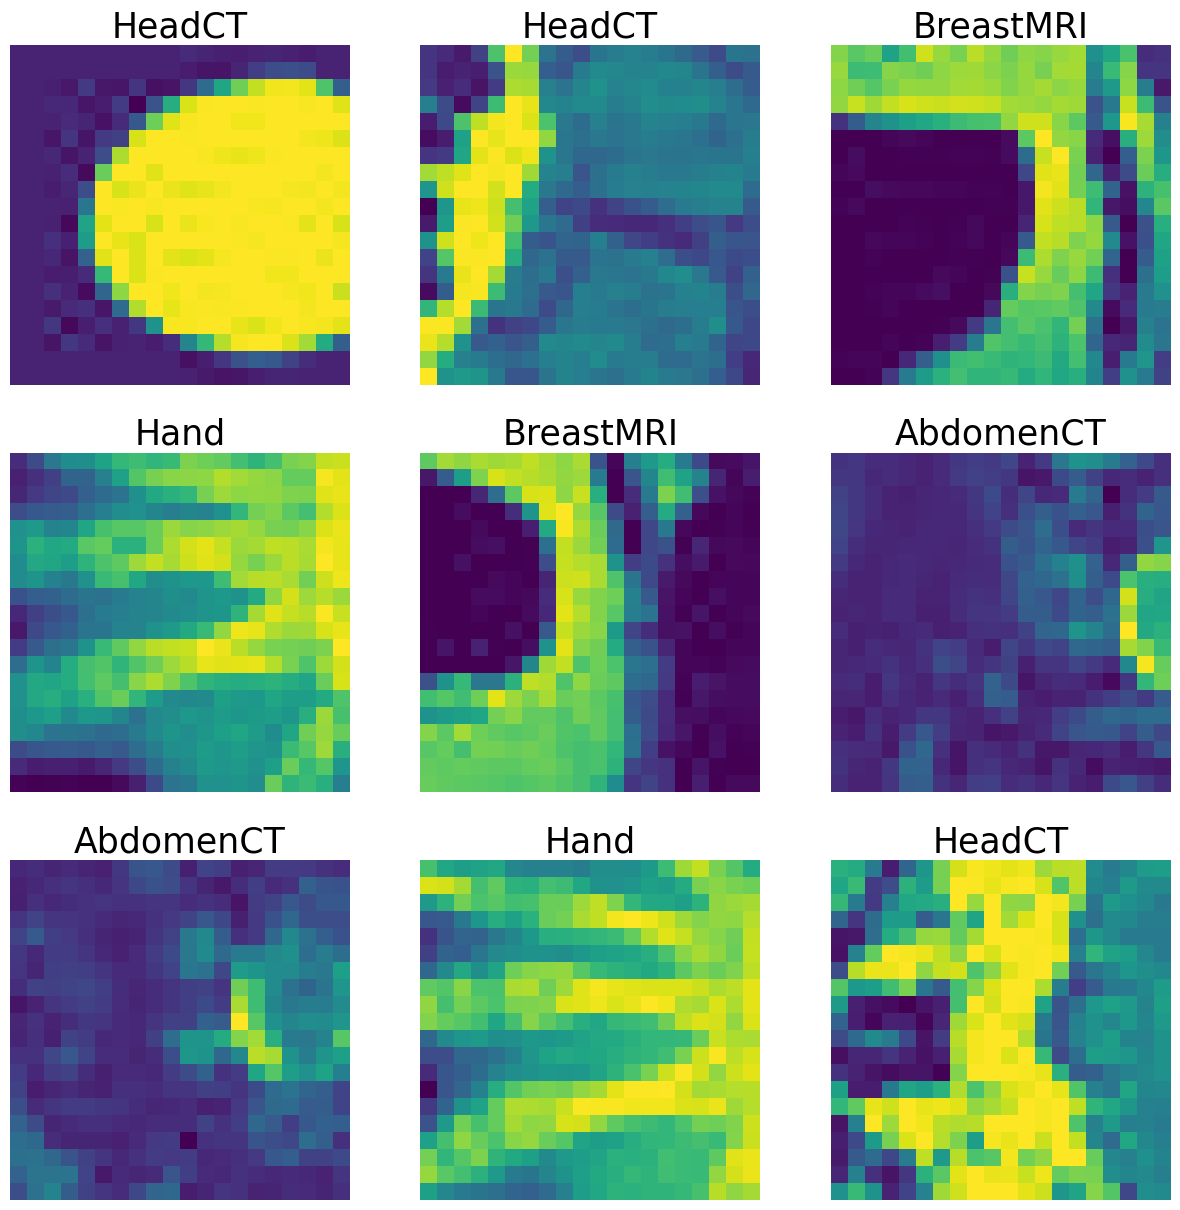

In [6]:
%matplotlib inline
fig, axes = plt.subplots(3, 3, figsize=(15, 15), facecolor="white")
for i, k in enumerate(np.random.randint(len(train_ds), size=9)):
    data = train_ds[k]
    im, title = data["image"], data["class_name"]
    ax = axes[i // 3, i % 3]
    im_show = ax.imshow(im[0])
    ax.set_title(title, fontsize=25)
    ax.axis("off")

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_function = torch.nn.CrossEntropyLoss()
auc_metric = ROCAUCMetric()


def get_new_net():
    return DenseNet(
        spatial_dims=2,
        in_channels=1,
        out_channels=num_classes,
        init_features=2,
        growth_rate=2,
        block_config=(2,),
    ).to(device)


model = get_new_net()

Computing optimal learning rate:  90%|█████████████████████████████████████████████████▌     | 18/20 [00:08<00:00,  2.19it/s]


Stopping early, the loss has diverged
Resetting model and optimizer


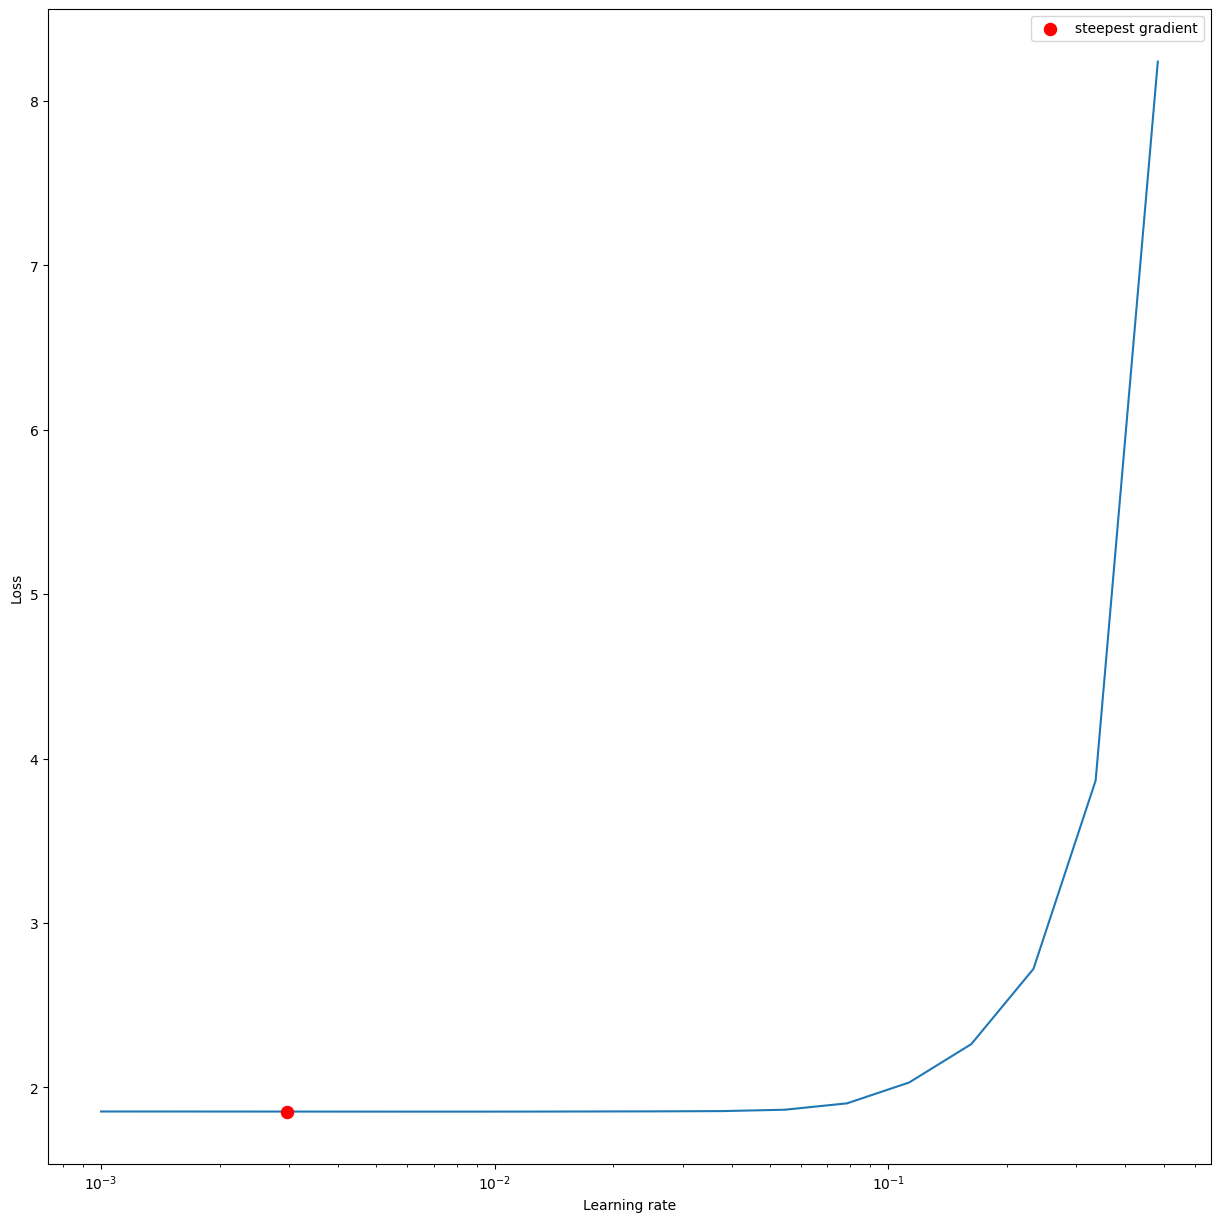

In [8]:


%matplotlib inline
lower_lr, upper_lr = 1e-3, 1e-0
optimizer = torch.optim.Adam(model.parameters(), lower_lr)
lr_finder = LearningRateFinder(model, optimizer, loss_function, device=device)
lr_finder.range_test(train_loader, val_loader, end_lr=upper_lr, num_iter=20)
steepest_lr, _ = lr_finder.get_steepest_gradient()
ax = plt.subplots(1, 1, figsize=(15, 15), facecolor="white")[1]
_ = lr_finder.plot(ax=ax)



In [9]:
def plot_range(data, wrapped_generator):
    plt.ion()
    for q in data.values():
        for d in q.values():
            if isinstance(d, dict):
                ax = d["line"].axes
                ax.legend()
                fig = ax.get_figure()
    fig.show()

    for i in wrapped_generator:
        yield i
        for q in data.values():
            for d in q.values():
                if isinstance(d, dict):
                    d["line"].set_data(d["x"], d["y"])
                    ax = d["line"].axes
                    ax.legend()
                    ax.relim()
                    ax.autoscale_view()
        fig.canvas.draw()

In [10]:
def get_model_optimizer_scheduler(d):
    d["model"] = get_new_net()

    if "lr_lims" in d:
        d["optimizer"] = torch.optim.Adam(
            d["model"].parameters(), d["lr_lims"][0]
        )
        d["scheduler"] = torch.optim.lr_scheduler.CyclicLR(
            d["optimizer"],
            base_lr=d["lr_lims"][0],
            max_lr=d["lr_lims"][1],
            step_size_up=d["step"],
            cycle_momentum=False,
        )
    elif "lr_lim" in d:
        d["optimizer"] = torch.optim.Adam(d["model"].parameters(), d["lr_lim"])
    else:
        d["optimizer"] = torch.optim.Adam(d["model"].parameters())


def train(max_epochs, axes, data):
    for d in data.keys():
        get_model_optimizer_scheduler(data[d])

        for q, i in enumerate(["train", "auc", "acc"]):
            data[d][i] = {"x": [], "y": []}
            (data[d][i]["line"],) = axes[q].plot(
                data[d][i]["x"], data[d][i]["y"], label=d
            )

        val_interval = 1

    for epoch in plot_range(data, trange(max_epochs)):

        for d in data.keys():
            data[d]["epoch_loss"] = 0
        for batch_data in train_loader:
            inputs = batch_data["image"].to(device)
            labels = batch_data["label"].to(device)

            for d in data.keys():
                data[d]["optimizer"].zero_grad()
                outputs = data[d]["model"](inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                data[d]["optimizer"].step()
                if "scheduler" in data[d]:
                    data[d]["scheduler"].step()
                data[d]["epoch_loss"] += loss.item()
        for d in data.keys():
            data[d]["epoch_loss"] /= len(train_loader)
            data[d]["train"]["x"].append(epoch + 1)
            data[d]["train"]["y"].append(data[d]["epoch_loss"])

        if (epoch + 1) % val_interval == 0:
            with eval_mode(*[data[d]["model"] for d in data.keys()]):
                for d in data:
                    data[d]["y_pred"] = torch.tensor(
                        [], dtype=torch.float32, device=device
                    )
                y = torch.tensor([], dtype=torch.long, device=device)
                for val_data in val_loader:
                    val_images = val_data["image"].to(device)
                    val_labels = val_data["label"].to(device)
                    for d in data:
                        data[d]["y_pred"] = torch.cat(
                            [data[d]["y_pred"], data[d]["model"](val_images)],
                            dim=0,
                        )
                    y = torch.cat([y, val_labels], dim=0)

                for d in data:
                    y_onehot = [y_trans(i) for i in decollate_batch(y)]
                    y_pred_act = [y_pred_trans(i).cpu() for i in decollate_batch(data[d]["y_pred"])]
                    auc_metric(y_pred_act, y_onehot)
                    auc_result = auc_metric.aggregate()
                    auc_metric.reset()
                    del y_pred_act, y_onehot
                    data[d]["auc"]["x"].append(epoch + 1)
                    data[d]["auc"]["y"].append(auc_result)

                    acc_value = torch.eq(data[d]["y_pred"].argmax(dim=1), y)
                    acc_metric = acc_value.sum().item() / len(acc_value)
                    data[d]["acc"]["x"].append(epoch + 1)
                    data[d]["acc"]["y"].append(acc_metric)

<IPython.core.display.Javascript object>


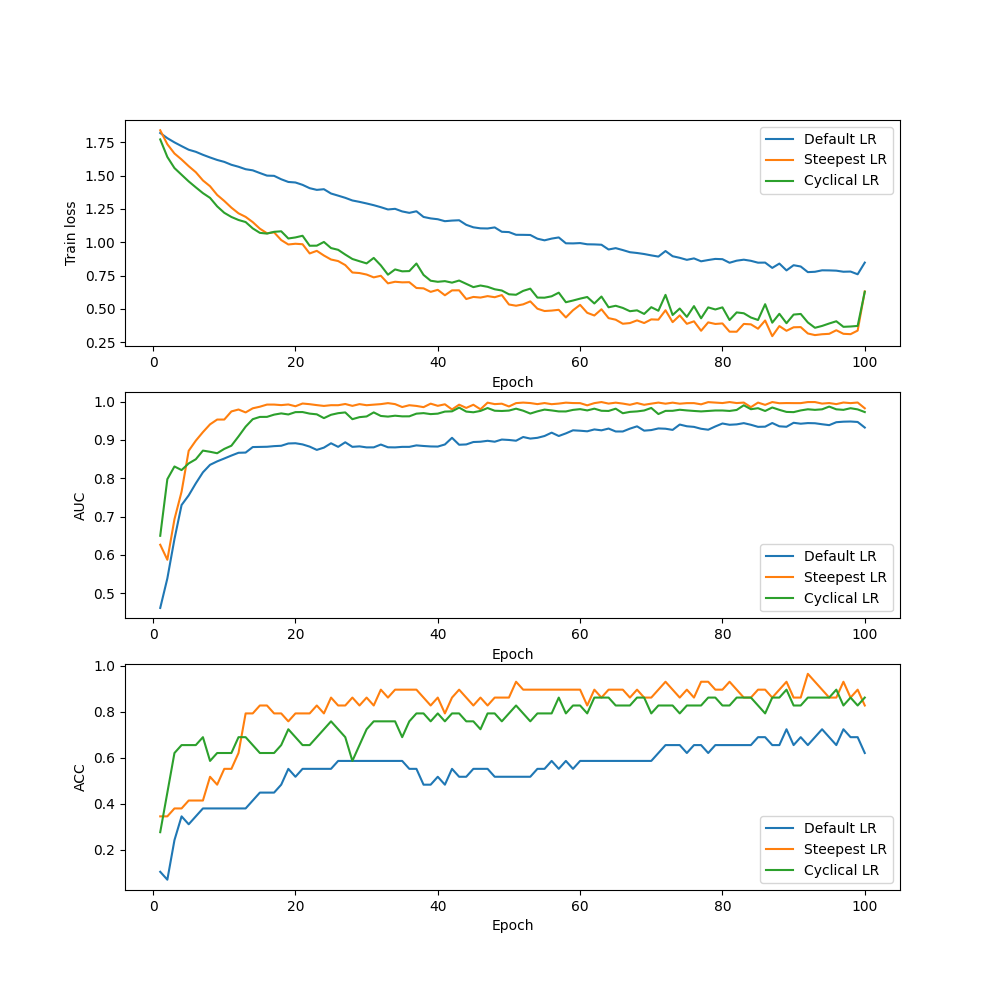

100%|██████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:48<00:00,  1.09s/it]


In [11]:
%matplotlib notebook
fig, axes = plt.subplots(3, 1, figsize=(10, 10), facecolor="white")
for ax in axes:
    ax.set_xlabel("Epoch")
axes[0].set_ylabel("Train loss")
axes[1].set_ylabel("AUC")
axes[2].set_ylabel("ACC")

# In the paper referenced at the top of this notebook, a step
# size of 8 times the number of iterations per epoch is suggested.
step_size = 8 * len(train_loader)

max_epochs = 100
data = {}
data["Default LR"] = {}
data["Steepest LR"] = {"lr_lim": steepest_lr}
data["Cyclical LR"] = {
    "lr_lims": (0.8 * steepest_lr, 1.2 * steepest_lr),
    "step": step_size,
}

train(max_epochs, axes, data)